In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import os
import seaborn as sns
import trackpy as tp

from glob import glob
from datetime import datetime
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit

import sys
sys.path.insert(0, "..")

from utils import fileio
from utils import visualise
from utils import geometry
from utils import matrices
from source import segmentation_hand
from source import graham_scan

In [2]:
shell_files=sorted(glob('C:\\Users/v35431nc/Documents/Lab_Stuff/Movies_to_track/Output/Unstretched_data/20231012_2_IP_GFPCAAX-CheHis_uu_0p5/*/*/Matrices/*shells.txt'))
mat_dir=sorted(glob('C:\\Users/v35431nc/Documents/Lab_Stuff/Movies_to_track/Output/Unstretched_data/20231012_2_IP_GFPCAAX-CheHis_uu_0p5/*/*/Matrices'))
dat_df=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP_pooled.csv')
plot_dir = 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_plots\\20231012_2_IP_GFPCAAX-CheHis_uu_0p5/'

In [75]:
mat_dir

['C:\\Users/v35431nc/Documents/Lab_Stuff/Movies_to_track/Output/Unstretched_data/20231012_2_IP_GFPCAAX-CheHis_uu_0p5\\20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP_fr001\\2024-04-30_10-27-39\\Matrices',
 'C:\\Users/v35431nc/Documents/Lab_Stuff/Movies_to_track/Output/Unstretched_data/20231012_2_IP_GFPCAAX-CheHis_uu_0p5\\20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP_fr006\\2024-04-30_10-28-37\\Matrices',
 'C:\\Users/v35431nc/Documents/Lab_Stuff/Movies_to_track/Output/Unstretched_data/20231012_2_IP_GFPCAAX-CheHis_uu_0p5\\20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP_fr011\\2024-04-30_10-29-33\\Matrices',
 'C:\\Users/v35431nc/Documents/Lab_Stuff/Movies_to_track/Output/Unstretched_data/20231012_2_IP_GFPCAAX-CheHis_uu_0p5\\20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP_fr016\\2024-04-30_10-30-23\\Matrices',
 'C:\\Users/v35431nc/Documents/Lab_Stuff/Movies_to_track/Output/Unstretched_data/20231012_2_IP_GFPCAAX-CheHis_uu_0p5\\20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP_fr021\\2024-04-30_10-31-17\\Matrices',
 'C:\\Users/v35431nc

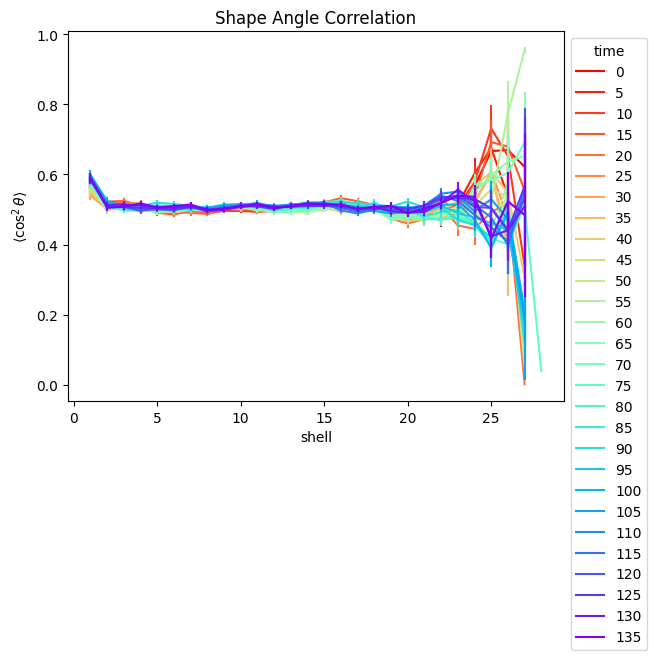

In [4]:
fig, ax=plt.subplots()

n=len(shell_files)
colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))

for i in range(n):
    c=next(colour)
    shell_matrix=np.loadtxt(shell_files[i])
    shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads.values,dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads.values))**2
    upper_triangle = np.triu_indices_from(shell_matrix, 1)
    c_func_shape_shell=pd.DataFrame({'shell': shell_matrix[upper_triangle],'cos_sq': shape_cos_sq[upper_triangle]})

    sns.lineplot(ax=ax,data=c_func_shape_shell, y='cos_sq', x='shell',err_style='bars', errorbar='se', label=str(i*5), c=c)
    plt.legend(title='time')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    plt.ylabel(r'$\langle\cos ^2 \theta\rangle$')
    plt.title('Shape Angle Correlation')

    #plt.xlim(0, 20)
    #plt.ylim(0.4, 0.85)
plt.savefig(plot_dir+'/shape_angle_correlations_nn_shells.png', dpi=300, bbox_inches='tight')
plt.show()



In [3]:
dat_df['dx']=dat_df.groupby('cell_id_new').diff().cc_x
dat_df['dy']=dat_df.groupby('cell_id_new').diff().cc_y
dat_df['vtheta']=np.arctan2(dat_df.dy, dat_df.dx)
dat_df['ds']=np.sqrt(dat_df.dx**2+dat_df.dy**2)

1


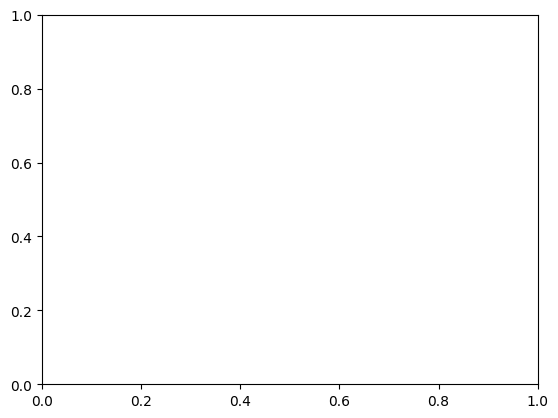

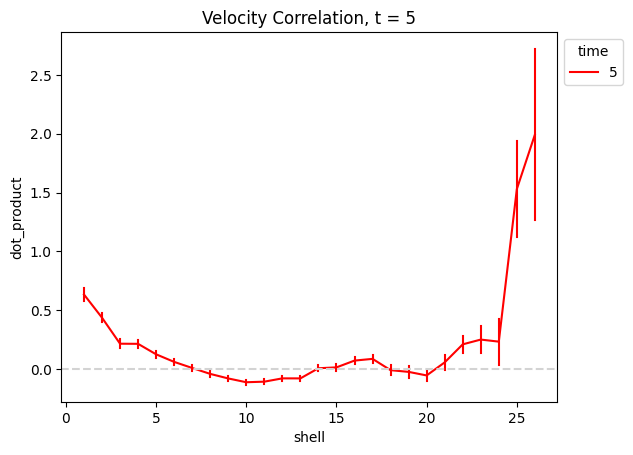

2


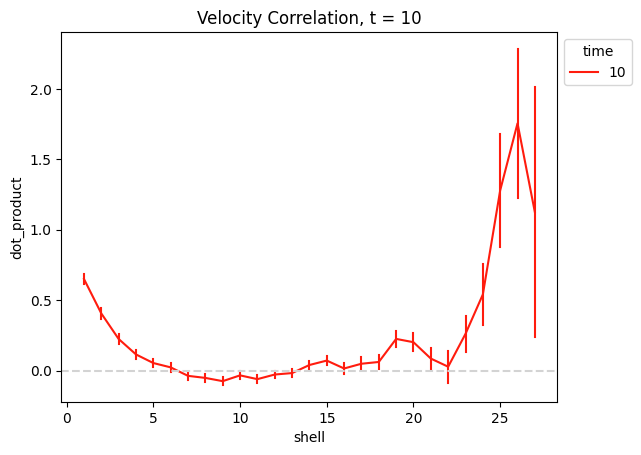

3


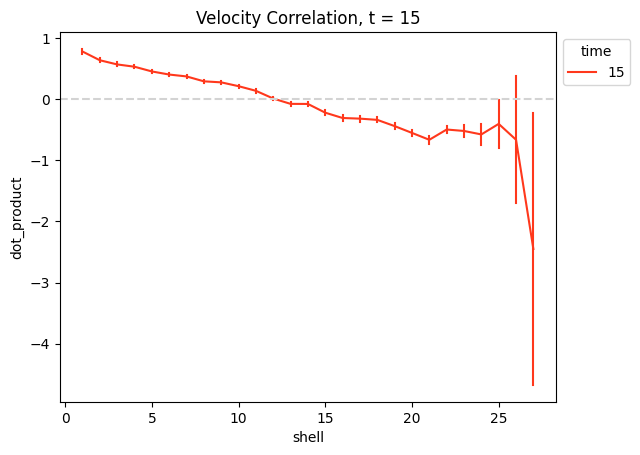

4


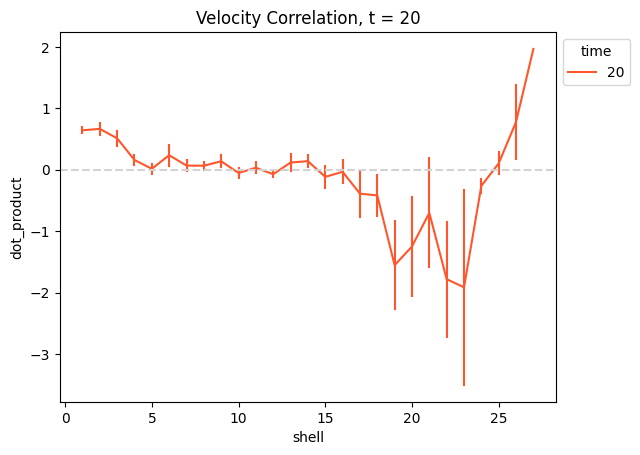

5


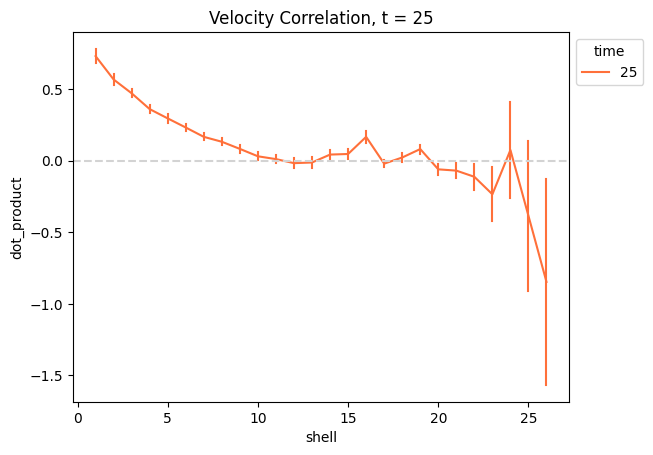

6


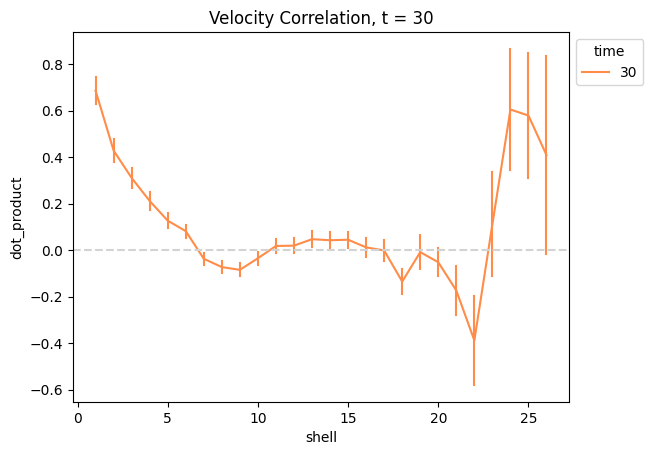

7


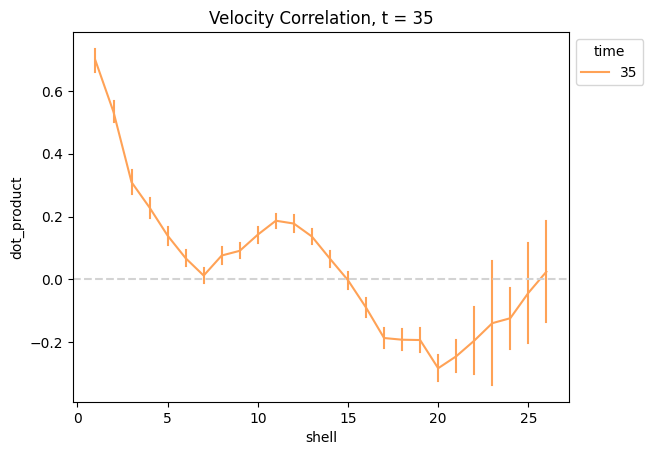

8


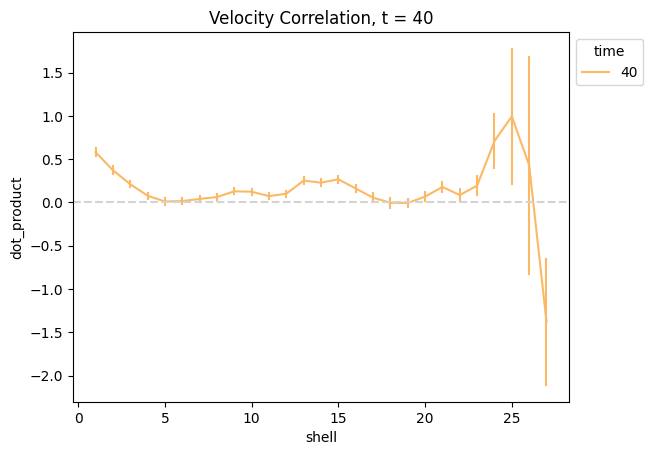

9


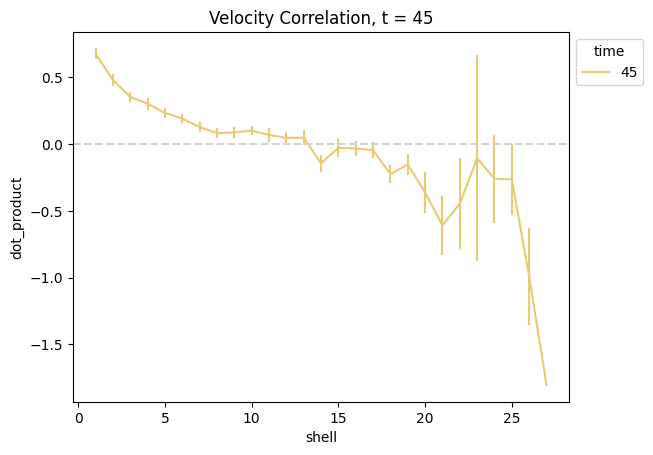

10


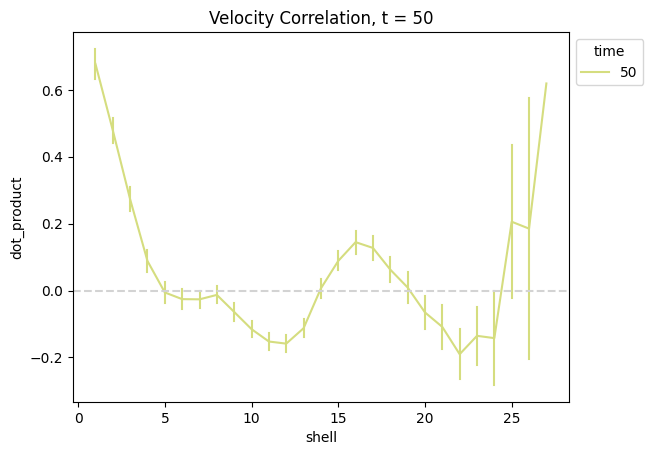

11


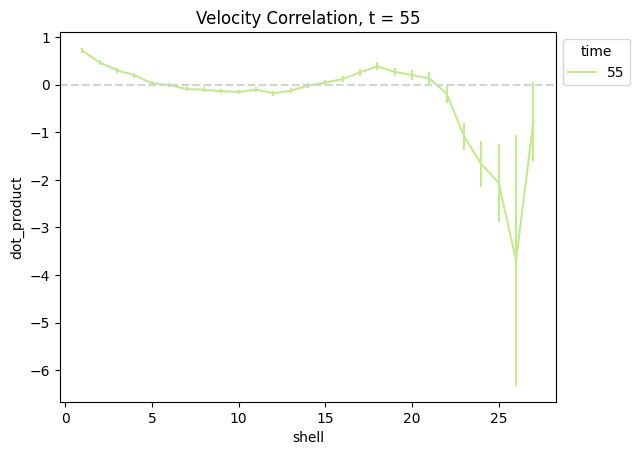

12


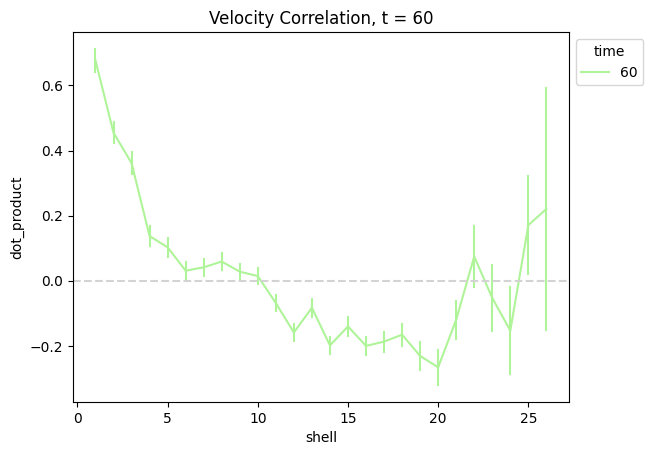

13


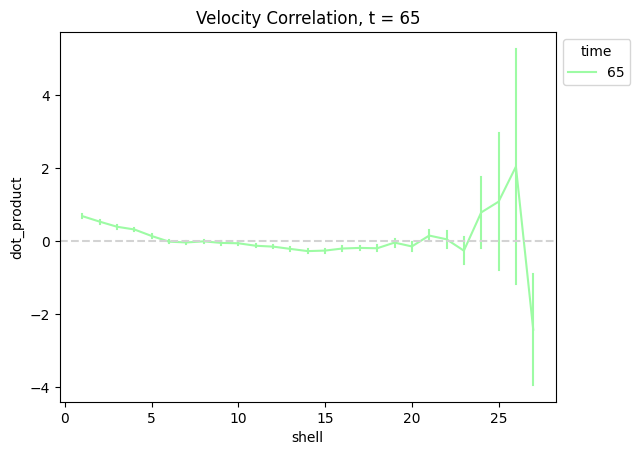

14


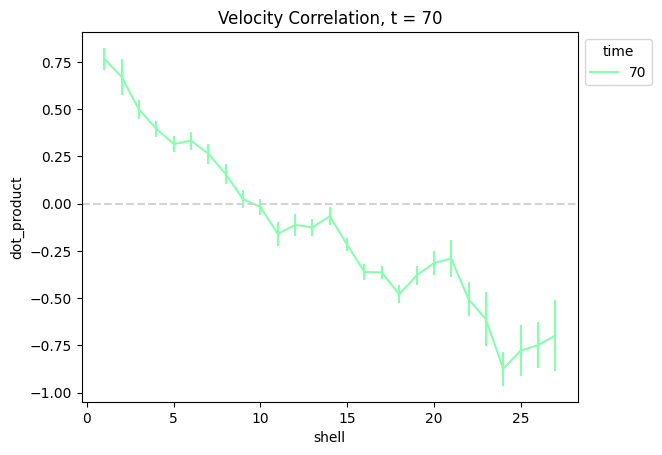

15


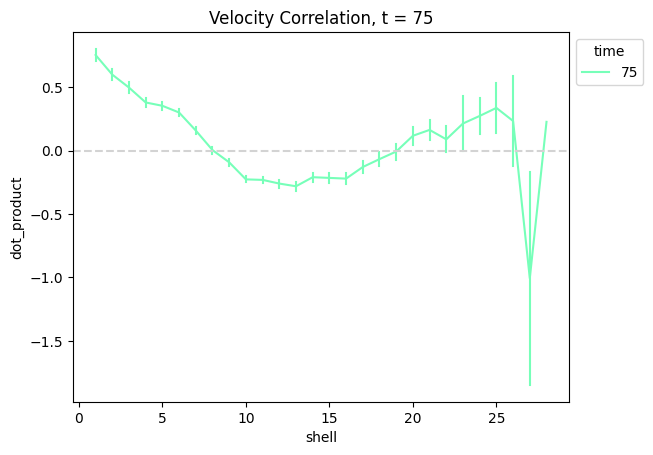

16


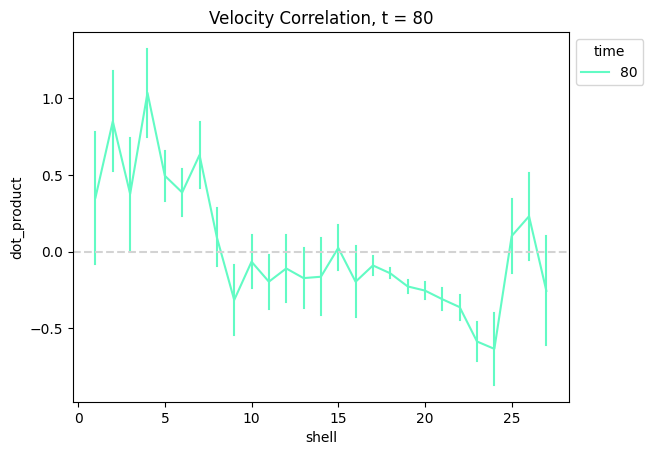

17


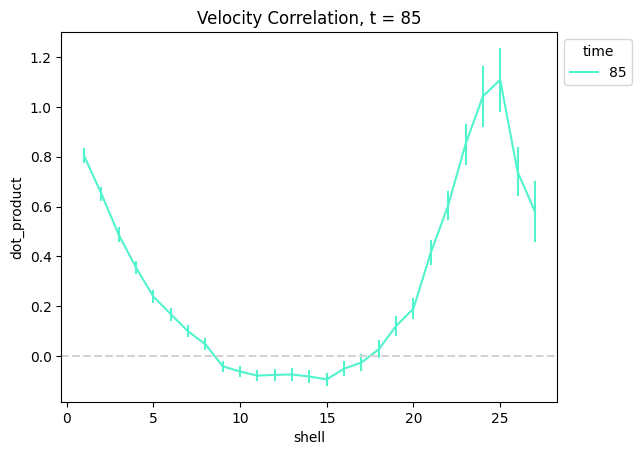

18


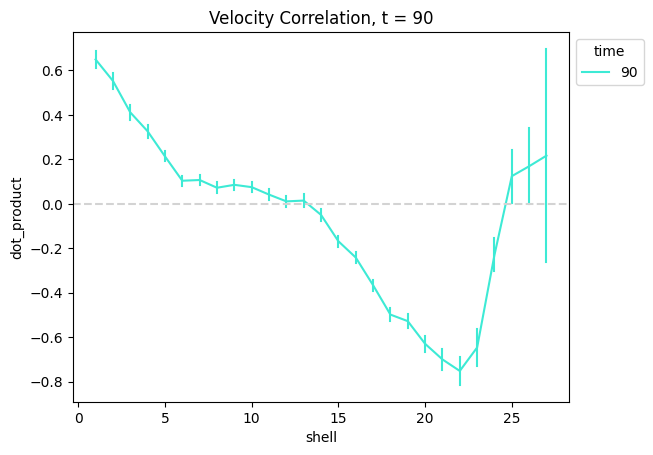

19


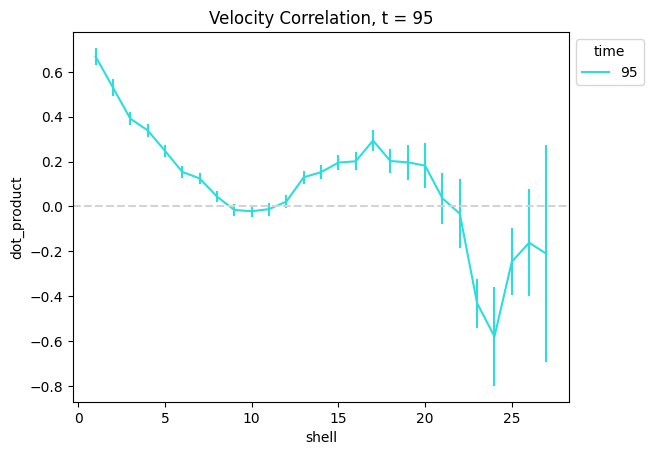

20


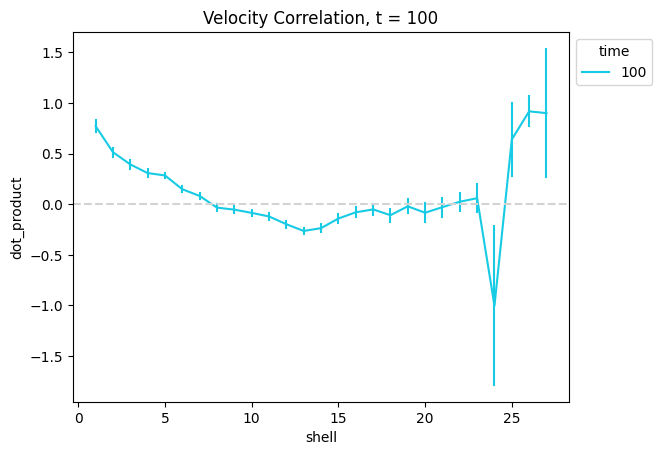

21


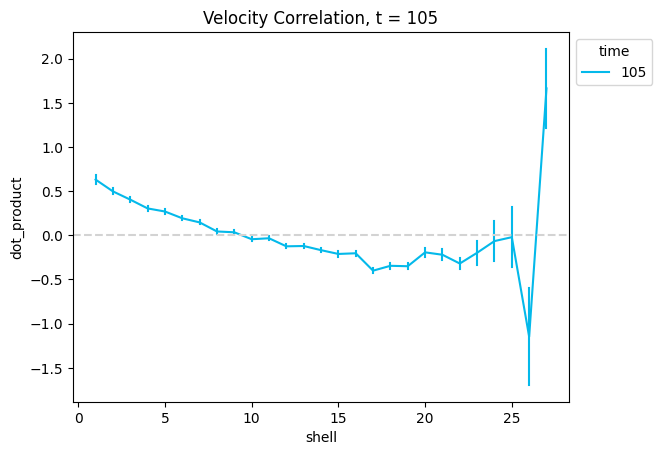

22


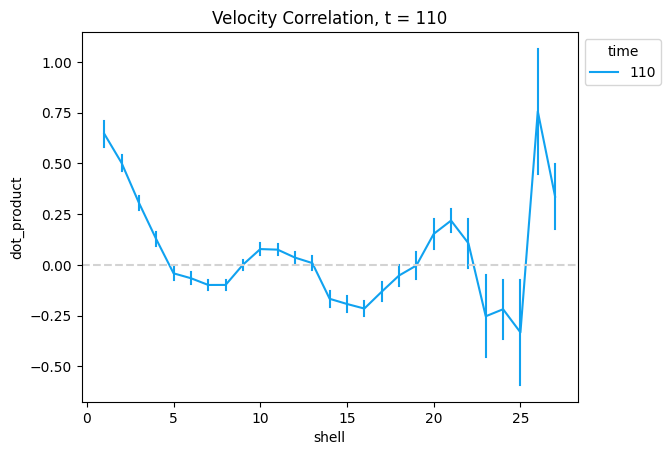

23


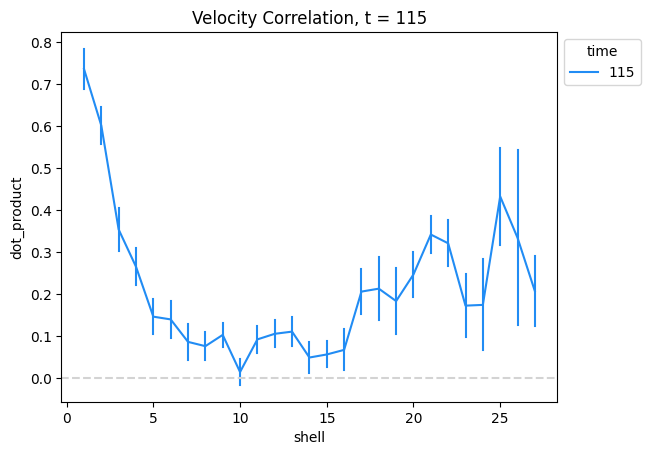

24


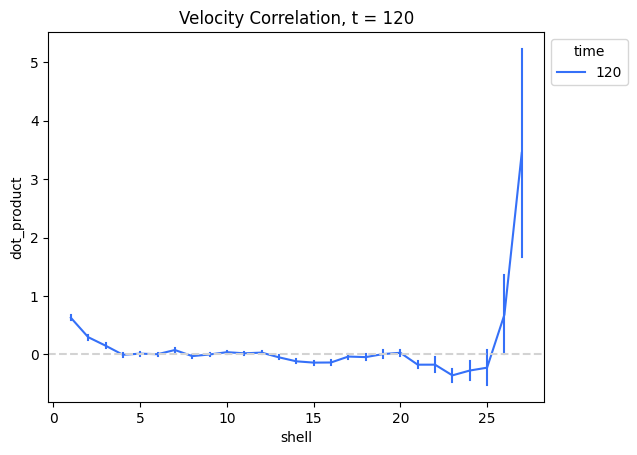

25


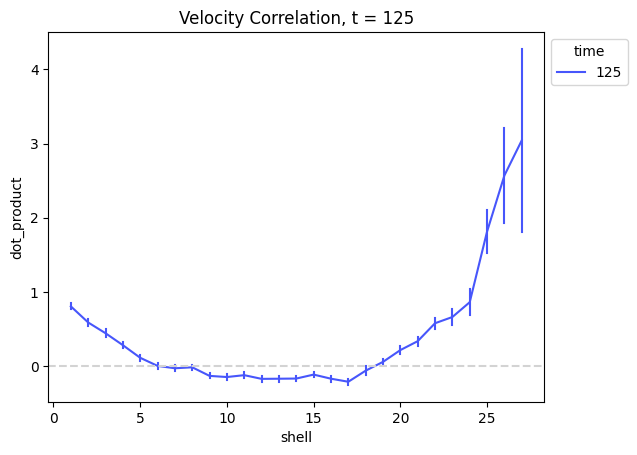

26


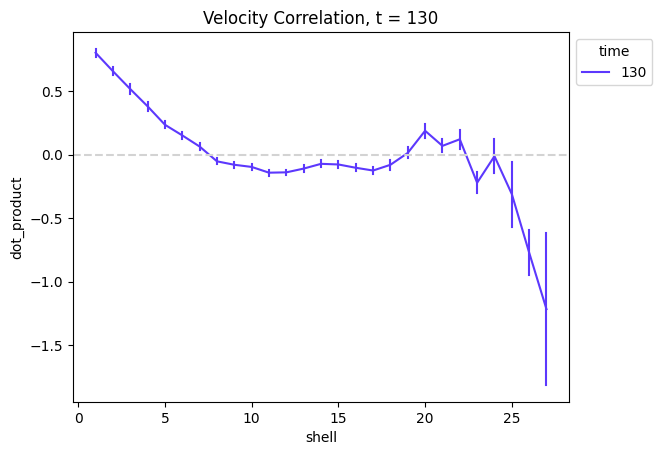

27


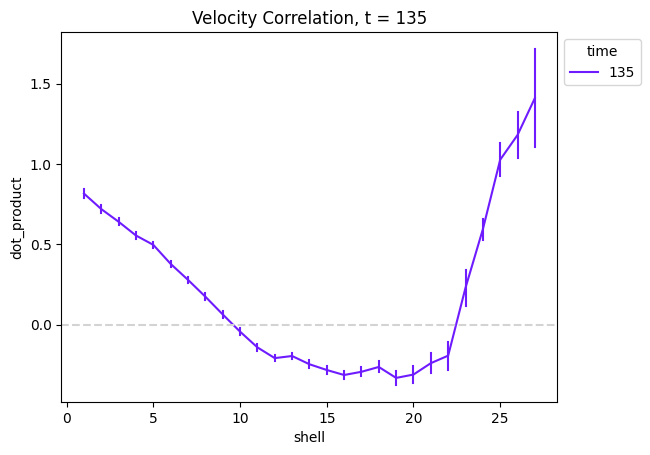

In [73]:
fig, ax=plt.subplots()

n=len(shell_files)
colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))

for i in range(1,n):
    print(i)
    c=next(colour)
    shell_matrix=np.loadtxt(shell_files[i])

    cells=list(set(dat_df[dat_df.tm_frame==i].cell_id_old).intersection(set(dat_df[dat_df.tm_frame==i-1].cell_id_old)))
    cell_corr=dat_df[(dat_df.cell_id_old.isin(cells))]

    shell_diff=list(set(np.unique(range(len(shell_matrix)))).difference(cells))
    new_shell_matrix=np.delete(np.delete(shell_matrix, shell_diff, 1),shell_diff,0)

    vcos=np.cos(np.subtract.outer(cell_corr[cell_corr.tm_frame==i].vtheta.values,cell_corr[cell_corr.tm_frame==i].vtheta.values))
    dot_product = vcos*np.abs(np.multiply.outer(cell_corr[cell_corr.tm_frame==i].ds.values, cell_corr[cell_corr.tm_frame==i].ds.values))
    dot_norm=(dot_product/dot_product.diagonal()).T
    upper_triangle = np.triu_indices_from(new_shell_matrix, 1)
    c_func_vel_shell=pd.DataFrame({'shell': shell_matrix[upper_triangle],'dot_product': dot_norm[upper_triangle]})
    fig, ax=plt.subplots()

    sns.lineplot(ax=ax,data=c_func_vel_shell, y='dot_product', x='shell',err_style='bars', errorbar='se', label=str(i*5), c=c)
    plt.legend(title='time')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    #plt.ylabel(r'$\langle\cos ^2 \theta\rangle$')
    plt.title('Velocity Correlation, t = '+ str(i*5))
    plt.axhline(0, color='lightgrey', linestyle='--')
    #plt.xlim(0, 20)
    #plt.ylim(0.4, 0.85)
    #plt.savefig(plot_dir+'/velocity_correlations_nn_shells'+ str(i*5)+'.png', dpi=300, bbox_inches='tight')
    plt.show()


#plt.savefig(plot_dir+'/velocity_correlations_nn_shells.png', dpi=300, bbox_inches='tight')




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


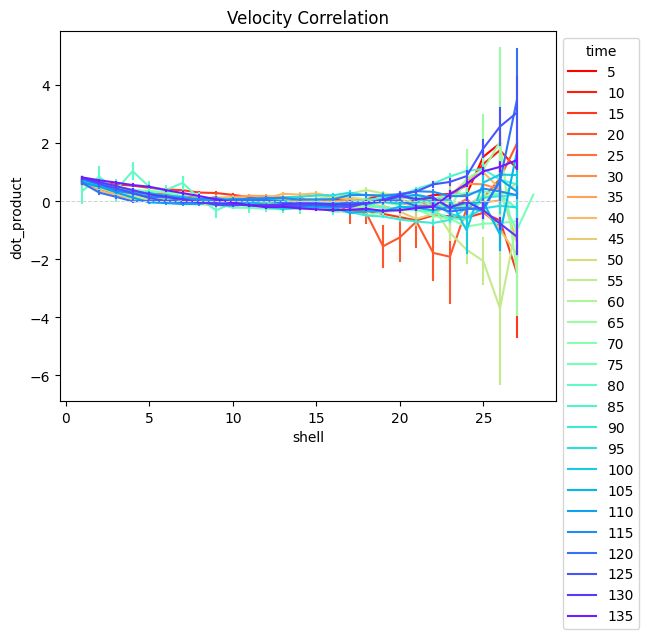

In [72]:
fig, ax=plt.subplots()

n=len(shell_files)
colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))

for i in range(1,n):
    print(i)
    c=next(colour)
    shell_matrix=np.loadtxt(shell_files[i])

    cells=list(set(dat_df[dat_df.tm_frame==i].cell_id_old).intersection(set(dat_df[dat_df.tm_frame==i-1].cell_id_old)))
    cell_corr=dat_df[(dat_df.cell_id_old.isin(cells))]

    shell_diff=list(set(np.unique(range(len(shell_matrix)))).difference(cells))
    new_shell_matrix=np.delete(np.delete(shell_matrix, shell_diff, 1),shell_diff,0)

    vcos=np.cos(np.subtract.outer(cell_corr[cell_corr.tm_frame==i].vtheta.values,cell_corr[cell_corr.tm_frame==i].vtheta.values))
    dot_product = vcos*np.abs(np.multiply.outer(cell_corr[cell_corr.tm_frame==i].ds.values, cell_corr[cell_corr.tm_frame==i].ds.values))
    dot_norm=(dot_product/dot_product.diagonal()).T
    upper_triangle = np.triu_indices_from(new_shell_matrix, 1)
    c_func_vel_shell=pd.DataFrame({'shell': shell_matrix[upper_triangle],'dot_product': dot_norm[upper_triangle]})

    sns.lineplot(ax=ax,data=c_func_vel_shell, y='dot_product', x='shell',err_style='bars', errorbar='se', label=str(i*5), c=c)
    plt.legend(title='time')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        
    
    #plt.ylabel(r'$\langle\cos ^2 \theta\rangle$')
    plt.title('Velocity Correlation')


ax.axhline(0, color='lightgrey', linestyle='--', linewidth=0.75)


#plt.savefig(plot_dir+'/velocity_correlations_nn_shells.png', dpi=300, bbox_inches='tight')
plt.show()


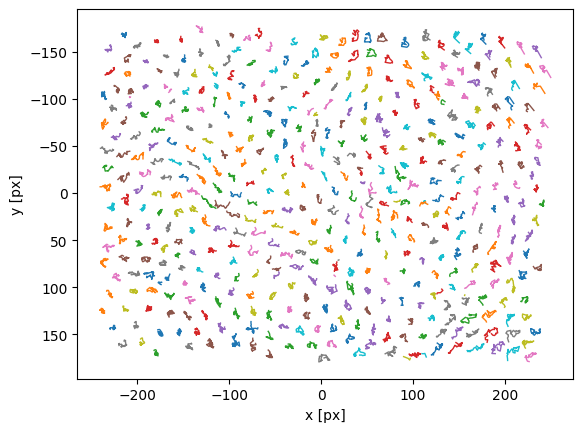

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

In [5]:
traj_dat=dat_df[['cc_x', 'cc_y', 'tm_frame', 'cell_id_new']]
traj_dat=traj_dat.rename(columns={"cc_y": "y", "cc_x": "x", "tm_frame":"frame", "cell_id_new":"particle"})
traj_dat
tp.plot_traj(traj_dat)

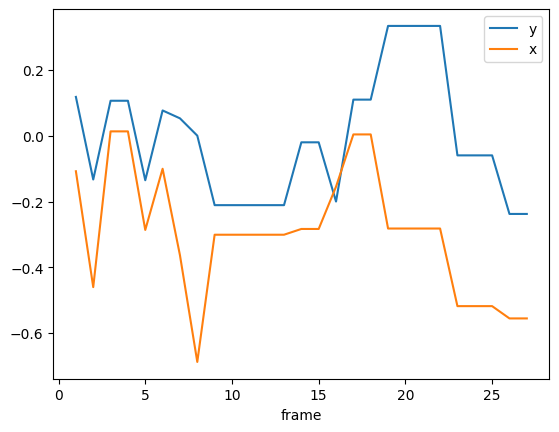

In [13]:


d = tp.compute_drift(traj_dat,1)
d.plot()
plt.show()



tm = tp.subtract_drift(traj_dat.copy(), d)



In [23]:
d

,y,x
frame,,
1,0.118465,-0.107668
2,-0.132839,-0.460176
3,0.106750,0.013604
4,0.106750,0.013604
5,-0.135059,-0.286253
6,0.077239,-0.100112
7,0.053259,-0.363052
8,0.000581,-0.687713
9,-0.210826,-0.300789


In [28]:
dat_df

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal,dx,dy,vtheta,ds
0,0.0,32.519242,48.950822,4.647939,0.528410,3.0,2.238215,118.098887,-60.827103,8,5160,0,0,NaN,0,0.903377,NaN,NaN,NaN,NaN
1,1.0,72.014271,295.166151,4.191653,0.302985,4.0,0.912612,-66.965042,-174.622499,63,5640,0,0,NaN,0,0.912612,NaN,NaN,NaN,NaN
2,2.0,60.730115,227.657853,4.024971,0.723802,4.0,1.816701,48.992736,-168.135350,60,5639,0,0,NaN,0,1.324892,NaN,NaN,NaN,NaN
3,3.0,61.655332,232.041509,4.047509,0.652449,4.0,0.205850,-88.453722,-154.620458,309,5585,0,0,NaN,0,0.205850,NaN,NaN,NaN,NaN
4,4.0,64.000409,236.279043,4.163611,0.531080,4.0,2.607028,-95.751764,-129.482757,203,5434,0,0,NaN,0,0.534565,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12472,447.0,87.447966,536.705581,3.774693,0.491236,8.0,2.926429,68.646455,-21.066504,340,14618,135,27,NaN,0,0.215163,0.651443,0.164630,0.247532,0.671924
12473,448.0,80.813891,464.667506,3.748995,0.663728,8.0,2.694745,130.477089,-13.160292,290,14589,135,27,NaN,0,0.446848,1.665060,0.164630,0.098553,1.673179
12474,449.0,86.187067,548.687573,3.679421,0.622647,8.0,1.846853,-29.268942,39.750513,61,14425,135,27,NaN,0,1.294739,-0.835195,-0.916562,-2.309779,1.240015
12475,450.0,82.639703,454.000610,3.878471,0.463332,8.0,1.730198,137.977854,39.345066,83,14422,135,27,NaN,0,1.411395,-0.362174,0.907949,1.950347,0.977518


In [30]:
new_dat=dat_df.copy()
new_dat=new_dat.rename(columns={"cc_y": "y", "cc_x": "x", "tm_frame":"frame", "cell_id_new":"particle"})
tm = tp.subtract_drift(new_dat.copy(), d)
tm[tm.frame==0].cell_id_old


frame
0      0.0
0      1.0
0      2.0
0      3.0
0      4.0
     ...  
0    431.0
0    432.0
0    433.0
0    434.0
0    435.0
Name: cell_id_old, Length: 436, dtype: float64

In [34]:
tm['dx']=tm.groupby('particle').diff().x
tm['dy']=tm.groupby('particle').diff().y
tm['vtheta']=np.arctan2(tm.dy, tm.dx)
tm['ds']=np.sqrt(tm.dx**2+tm.dy**2)

In [63]:
(dot_product.diagonal()[0])

7.819336996155552

In [64]:
dot_product/(dot_product.diagonal()[0])

array([[ 1.        ,  0.29707491,  0.65191374, ..., -0.43706745,
         0.09742388, -0.59428246],
       [ 0.29707491,  0.60455872,  0.57111814, ..., -0.07598759,
        -0.21229045,  0.16351201],
       [ 0.65191374,  0.57111814,  0.7009314 , ..., -0.24555955,
        -0.11284396, -0.13881724],
       ...,
       [-0.43706745, -0.07598759, -0.24555955, ...,  0.19664531,
        -0.06774303,  0.29521195],
       [ 0.09742388, -0.21229045, -0.11284396, ..., -0.06774303,
         0.12220224, -0.21678238],
       [-0.59428246,  0.16351201, -0.13881724, ...,  0.29521195,
        -0.21678238,  0.57714716]])

In [67]:
(dot_product/dot_product.diagonal()).T

array([[ 1.        ,  0.29707491,  0.65191374, ..., -0.43706745,
         0.09742388, -0.59428246],
       [ 0.49139133,  1.        ,  0.94468598, ..., -0.125691  ,
        -0.35114943,  0.27046506],
       [ 0.93006781,  0.81479891,  1.        , ..., -0.35033321,
        -0.16099144, -0.19804683],
       ...,
       [-2.22261816, -0.38641953, -1.24874343, ...,  1.        ,
        -0.34449349,  1.5012407 ],
       [ 0.79723483, -1.73720589, -0.92341973, ..., -0.55435179,
         1.        , -1.77396402],
       [-1.02968965,  0.28331077, -0.24052313, ...,  0.51150204,
        -0.37561023,  1.        ]])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


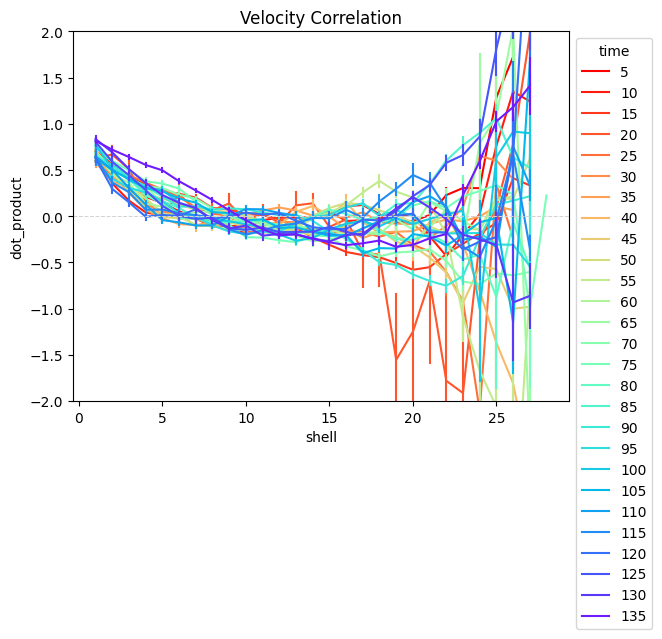

In [68]:
fig, ax=plt.subplots()

n=len(shell_files)
colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))

for i in range(1,n):
    print(i)
    c=next(colour)
    shell_matrix=np.loadtxt(shell_files[i])

    cells=list(set(tm[tm.frame==i].cell_id_old).intersection(set(tm[tm.frame==i-1].cell_id_old)))
    cell_corr=tm[(tm.cell_id_old.isin(cells))]

    shell_diff=list(set(np.unique(range(len(shell_matrix)))).difference(cells))
    new_shell_matrix=np.delete(np.delete(shell_matrix, shell_diff, 1),shell_diff,0)

    vcos=np.cos(np.subtract.outer(cell_corr[cell_corr.frame==i].vtheta.values,cell_corr[cell_corr.frame==i].vtheta.values))
    dot_product = vcos*np.abs(np.multiply.outer(cell_corr[cell_corr.frame==i].ds.values, cell_corr[cell_corr.frame==i].ds.values))
    dot_norm=(dot_product/dot_product.diagonal()).T
    upper_triangle = np.triu_indices_from(new_shell_matrix, 1)
    c_func_vel_shell=pd.DataFrame({'shell': shell_matrix[upper_triangle],'dot_product': dot_norm[upper_triangle]})

    sns.lineplot(ax=ax,data=c_func_vel_shell, y='dot_product', x='shell',err_style='bars', errorbar='se', label=str(i*5), c=c)
    plt.legend(title='time')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        
    plt.ylim(-2, 2)
    #plt.ylabel(r'$\langle\cos ^2 \theta\rangle$')
    plt.title('Velocity Correlation')


ax.axhline(0, color='lightgrey', linestyle='--', linewidth=0.75)


#plt.savefig(plot_dir+'/velocity_correlations_nn_shells.png', dpi=300, bbox_inches='tight')
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


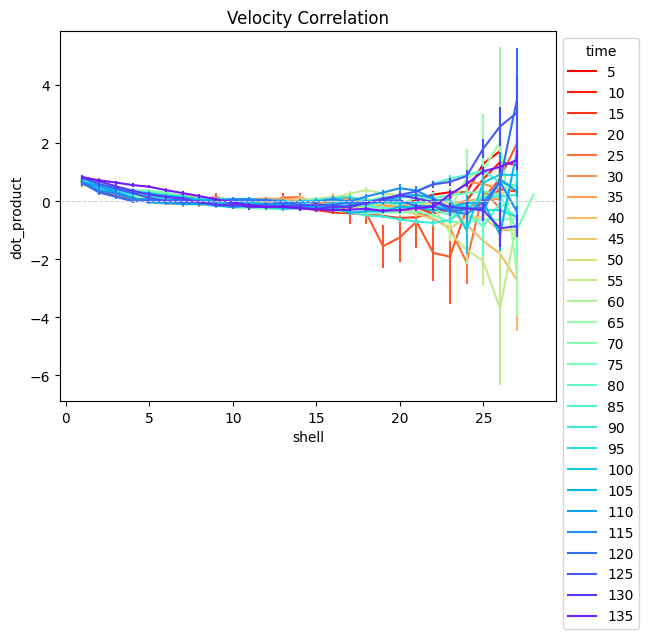

In [70]:
fig, ax=plt.subplots()

n=len(shell_files)
colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))

for i in range(1,n):
    print(i)
    c=next(colour)
    shell_matrix=np.loadtxt(shell_files[i])

    cells=list(set(tm[tm.frame==i].cell_id_old).intersection(set(tm[tm.frame==i-1].cell_id_old)))
    cell_corr=tm[(tm.cell_id_old.isin(cells))]

    shell_diff=list(set(np.unique(range(len(shell_matrix)))).difference(cells))
    new_shell_matrix=np.delete(np.delete(shell_matrix, shell_diff, 1),shell_diff,0)

    vcos=np.cos(np.subtract.outer(cell_corr[cell_corr.frame==i].vtheta.values,cell_corr[cell_corr.frame==i].vtheta.values))
    dot_product = vcos*np.abs(np.multiply.outer(cell_corr[cell_corr.frame==i].ds.values, cell_corr[cell_corr.frame==i].ds.values))
    dot_norm=(dot_product/dot_product.diagonal()).T
    upper_triangle = np.triu_indices_from(new_shell_matrix, 1)
    c_func_vel_shell=pd.DataFrame({'shell': shell_matrix[upper_triangle],'dot_product': dot_norm[upper_triangle]})

    sns.lineplot(ax=ax,data=c_func_vel_shell, y='dot_product', x='shell',err_style='bars', errorbar='se', label=str(i*5), c=c)
    plt.legend(title='time')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        

    #plt.ylabel(r'$\langle\cos ^2 \theta\rangle$')
    plt.title('Velocity Correlation')


ax.axhline(0, color='lightgrey', linestyle='--', linewidth=0.75)


#plt.savefig(plot_dir+'/velocity_correlations_nn_shells.png', dpi=300, bbox_inches='tight')
plt.show()

In [79]:
dat_df[dat_df.tm_frame==0]

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal
0,0.0,32.519242,48.950822,4.647939,0.528410,3.0,2.238215,118.098887,-60.827103,8,5160,0,0,NaN,0,0.903377
1,1.0,72.014271,295.166151,4.191653,0.302985,4.0,0.912612,-66.965042,-174.622499,63,5640,0,0,NaN,0,0.912612
2,2.0,60.730115,227.657853,4.024971,0.723802,4.0,1.816701,48.992736,-168.135350,60,5639,0,0,NaN,0,1.324892
3,3.0,61.655332,232.041509,4.047509,0.652449,4.0,0.205850,-88.453722,-154.620458,309,5585,0,0,NaN,0,0.205850
4,4.0,64.000409,236.279043,4.163611,0.531080,4.0,2.607028,-95.751764,-129.482757,203,5434,0,0,NaN,0,0.534565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,431.0,92.967852,586.240891,3.839677,0.533893,8.0,0.427494,215.158340,89.120630,391,3336,0,0,NaN,0,0.427494
432,432.0,87.342687,536.413337,3.771176,0.425545,8.0,1.382433,6.285675,118.583096,310,3080,0,0,NaN,0,1.382433
433,433.0,96.573138,636.799053,3.826971,0.316063,8.0,0.768268,-173.192098,150.951264,180,2546,0,0,NaN,0,0.768268
434,434.0,77.803278,391.606577,3.931632,0.641921,8.0,0.833200,51.019970,163.520114,124,2427,0,0,NaN,0,0.833200


In [82]:
traj=dat_df.copy()
traj['c_x']=0
traj['c_y']=0

In [86]:

for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)
    traj.loc[traj.tm_frame==i,'c_x']=cc[:,0]
    traj.loc[traj.tm_frame==i, 'c_y']=cc[:,1]

traj=traj.rename(columns={"c_y": "y", "c_x": "x", "tm_frame":"frame", "cell_id_new":"particle"})



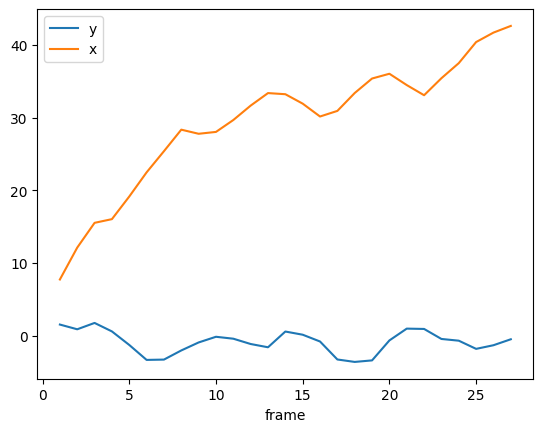

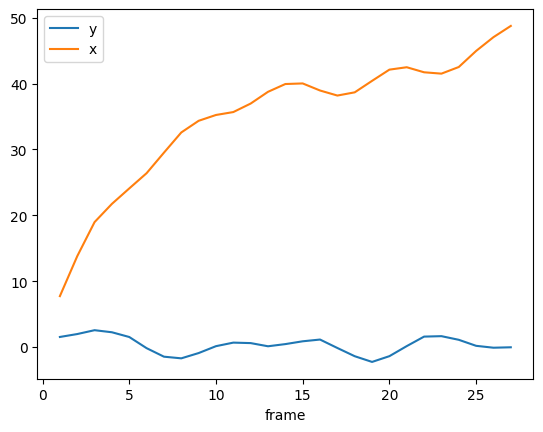

In [100]:

d = tp.compute_drift(traj,0)
d.plot()
d2 = tp.compute_drift(traj,3)
d2.plot()
plt.show()



tm = tp.subtract_drift(traj.copy(), d2)

In [101]:
tm['dx']=tm.groupby('particle').diff().x
tm['dy']=tm.groupby('particle').diff().y
tm['vtheta']=np.arctan2(tm.dy, tm.dx)
tm['ds']=np.sqrt(tm.dx**2+tm.dy**2)

In [23]:
dot_norm

NameError: name 'dot_norm' is not defined

1


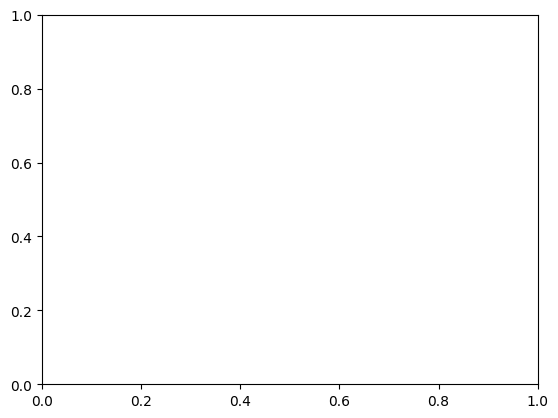

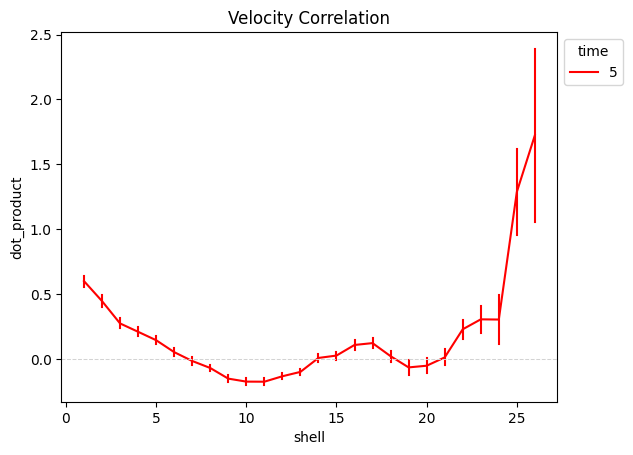

2


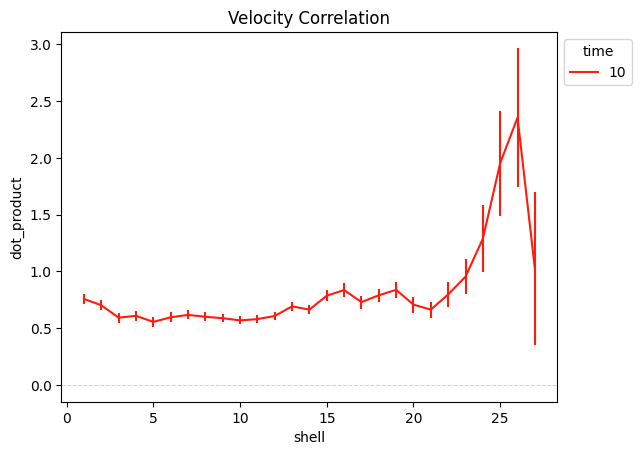

3


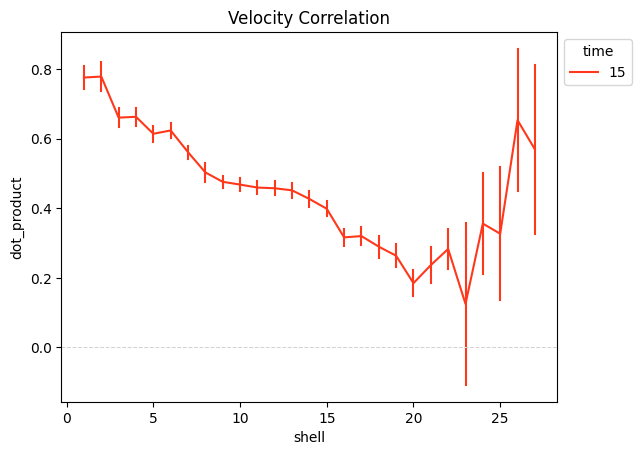

4


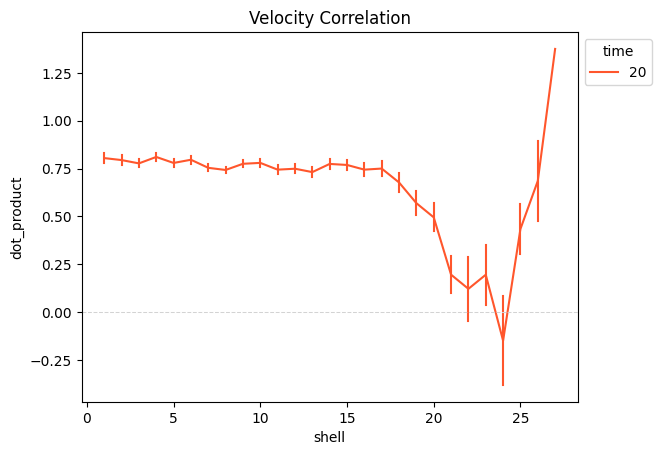

5


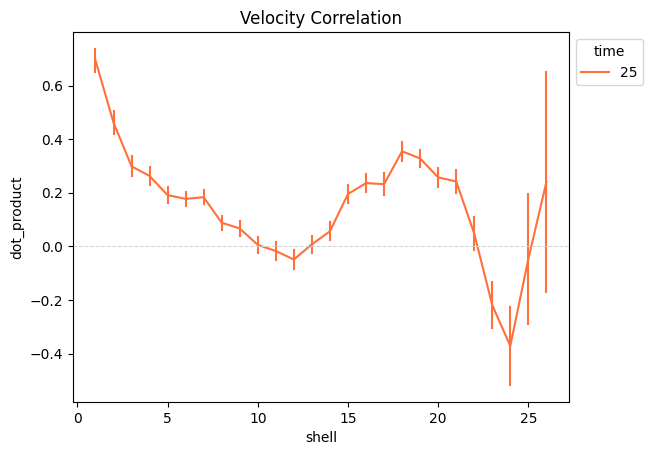

6


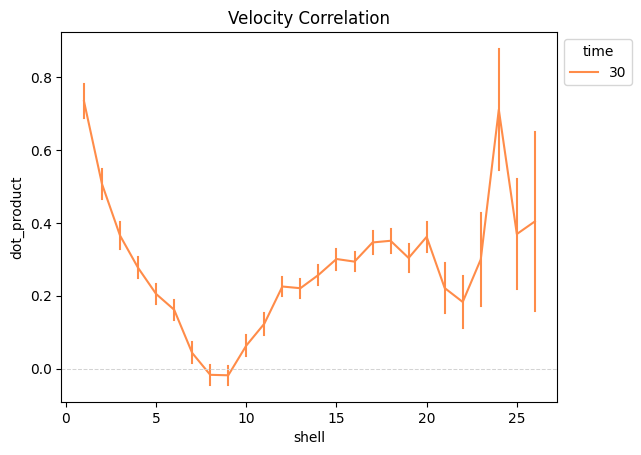

7


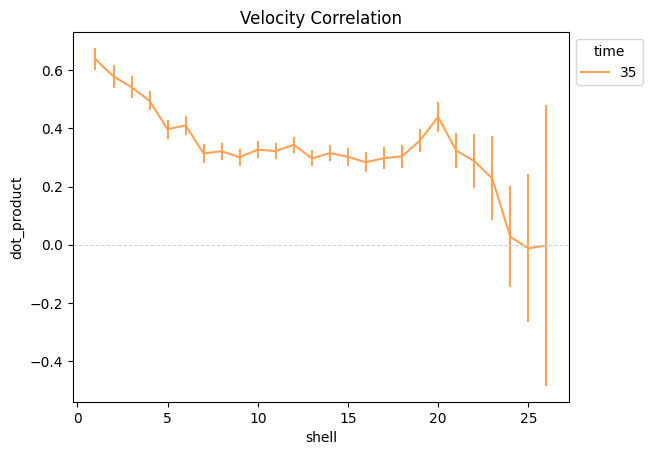

8


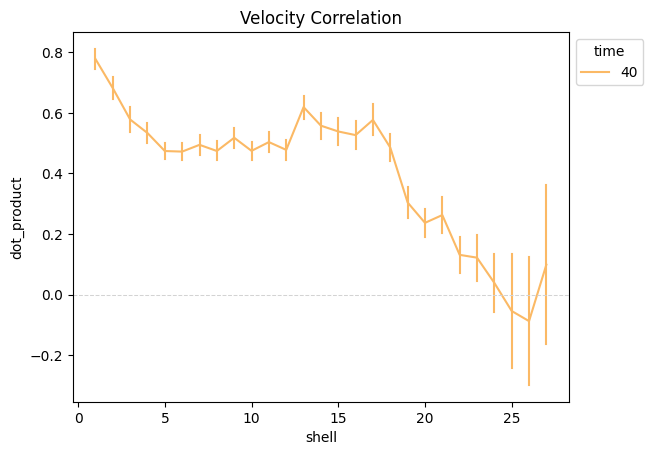

9


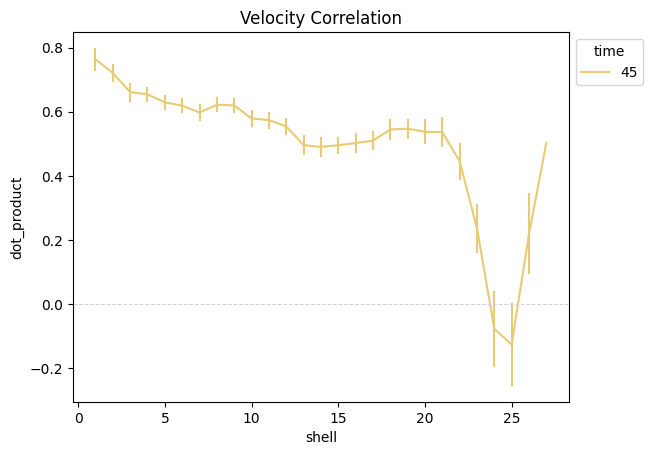

10


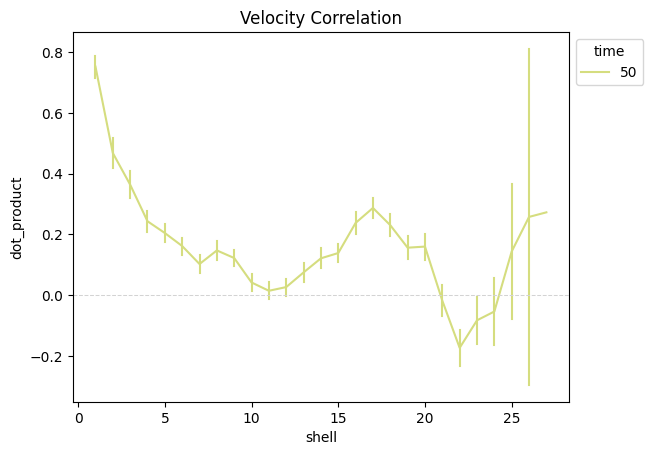

11


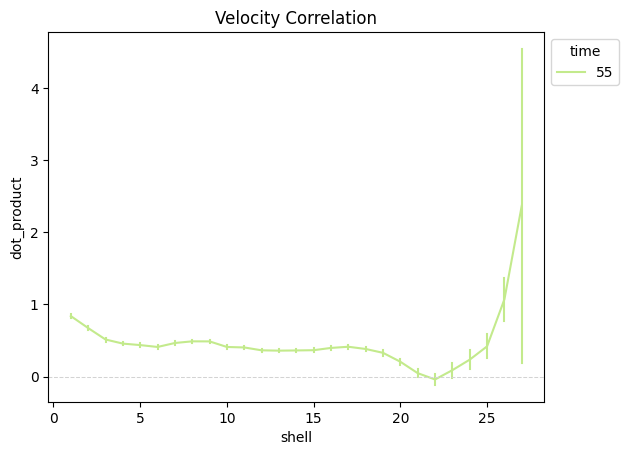

12


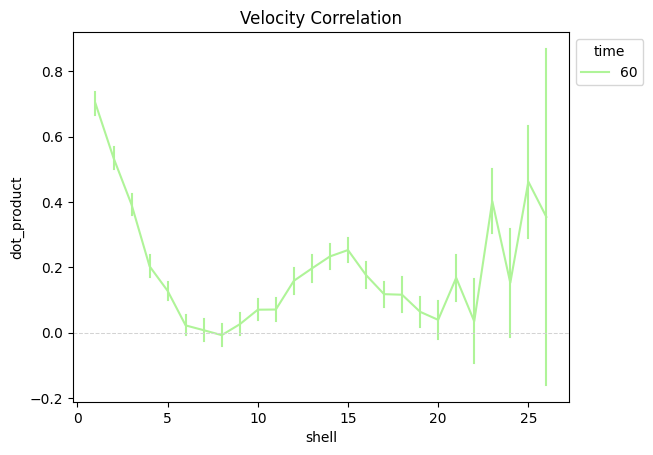

13


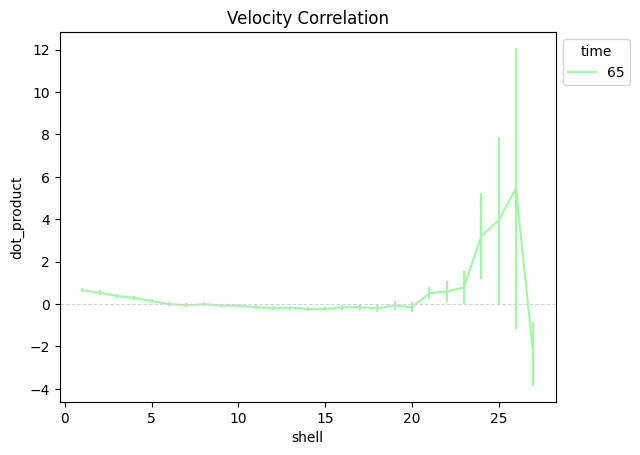

14


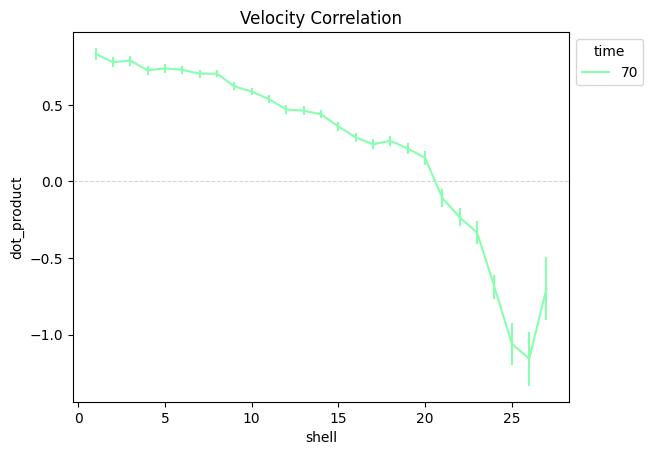

15


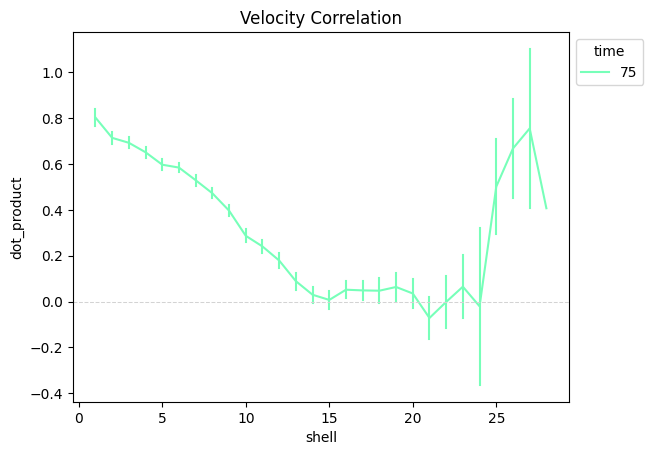

16


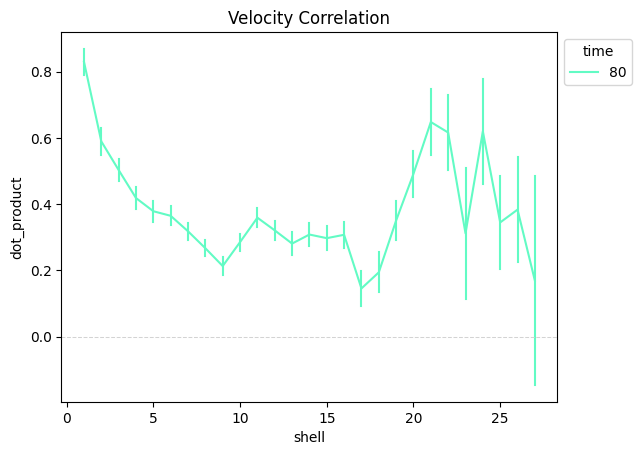

17


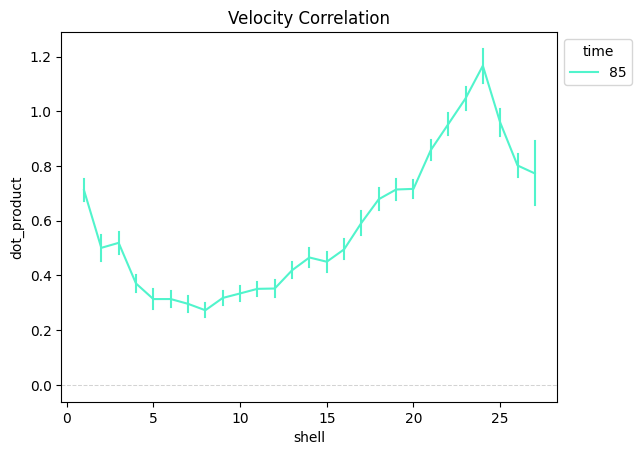

18


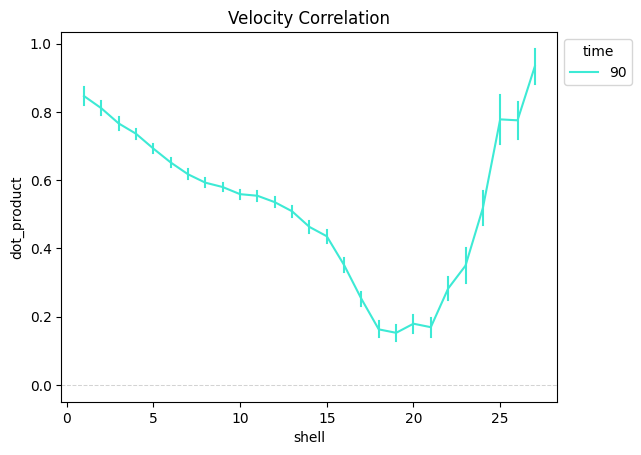

19


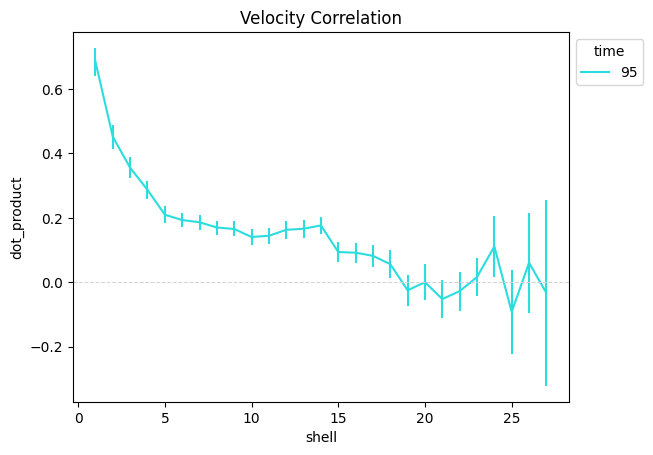

20


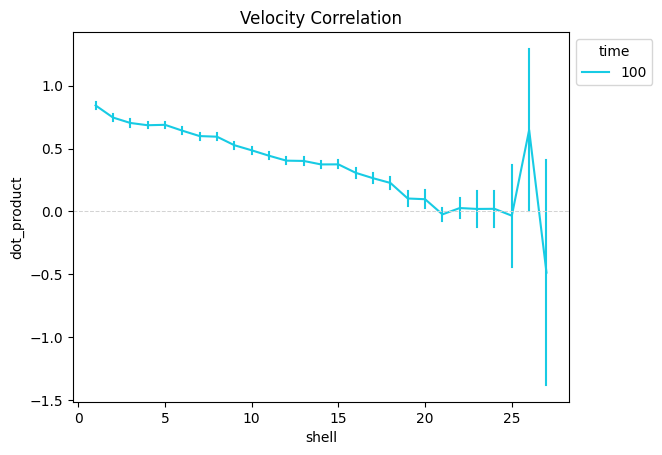

21


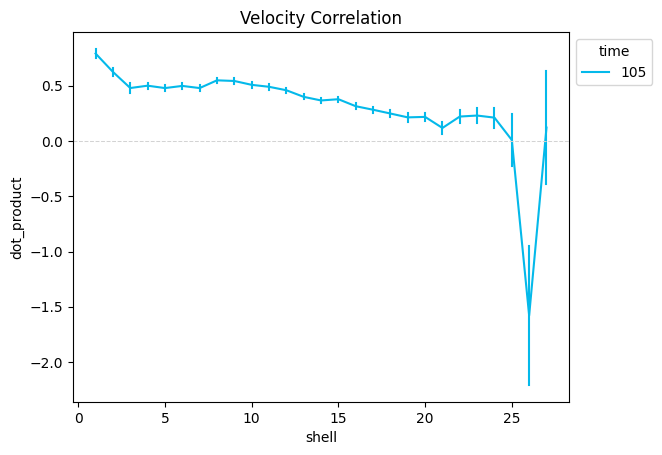

22


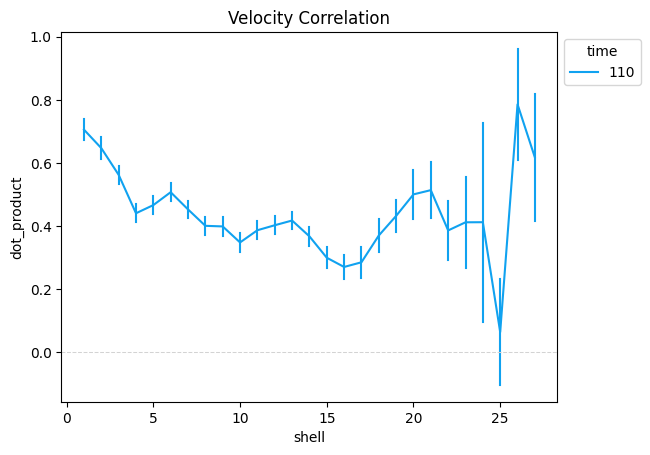

23


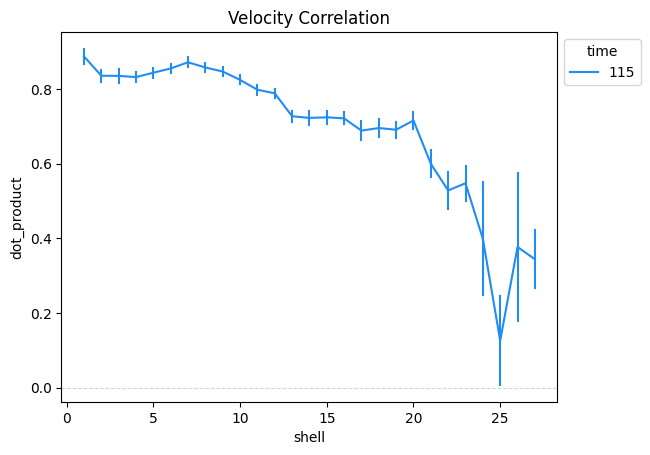

24


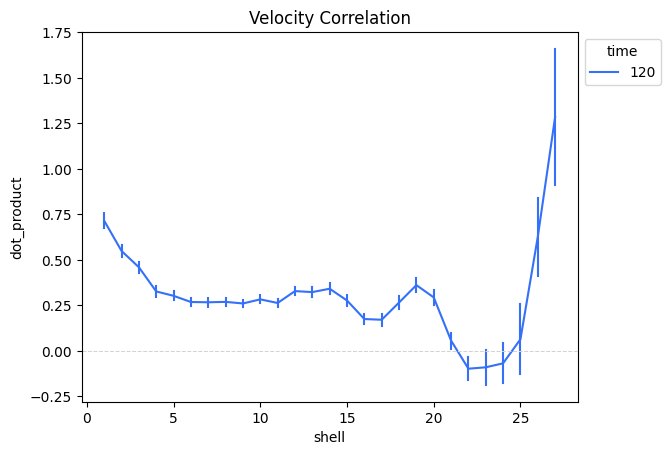

25


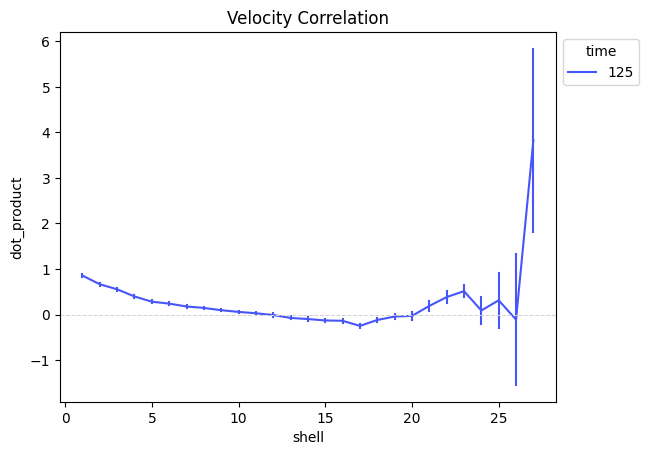

26


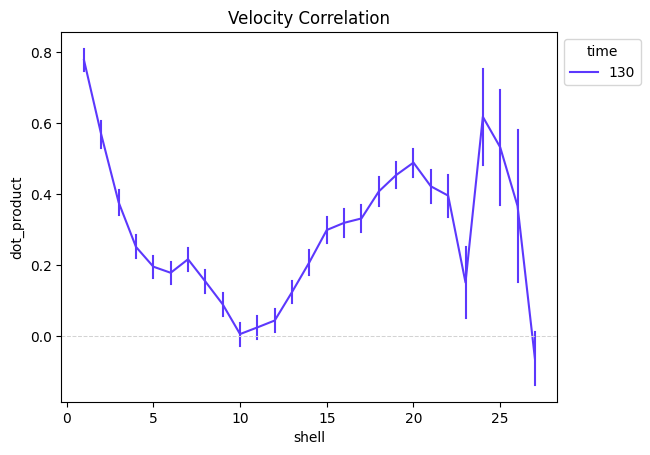

27


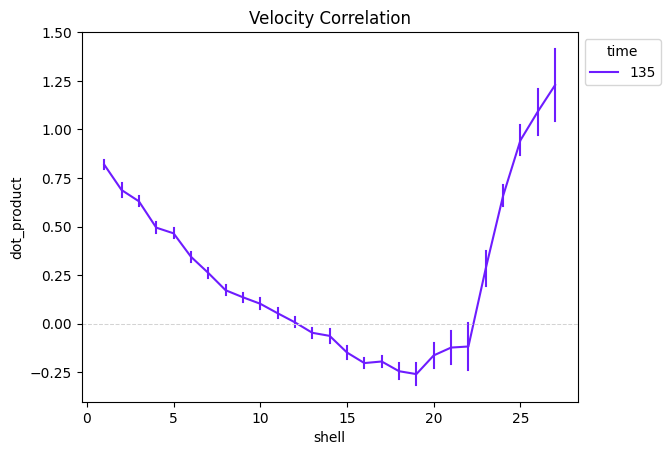

In [103]:
fig, ax=plt.subplots()

n=len(shell_files)
colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))

for i in range(1,n):
    print(i)
    c=next(colour)
    shell_matrix=np.loadtxt(shell_files[i])

    cells=list(set(tm[tm.frame==i].cell_id_old).intersection(set(tm[tm.frame==i-1].cell_id_old)))
    cell_corr=tm[(tm.cell_id_old.isin(cells))]

    shell_diff=list(set(np.unique(range(len(shell_matrix)))).difference(cells))
    new_shell_matrix=np.delete(np.delete(shell_matrix, shell_diff, 1),shell_diff,0)

    vcos=np.cos(np.subtract.outer(cell_corr[cell_corr.frame==i].vtheta.values,cell_corr[cell_corr.frame==i].vtheta.values))
    dot_product = vcos*np.abs(np.multiply.outer(cell_corr[cell_corr.frame==i].ds.values, cell_corr[cell_corr.frame==i].ds.values))
    dot_norm=(dot_product/dot_product.diagonal()).T
    upper_triangle = np.triu_indices_from(new_shell_matrix, 1)
    c_func_vel_shell=pd.DataFrame({'shell': shell_matrix[upper_triangle],'dot_product': dot_norm[upper_triangle]})

    fig, ax=plt.subplots()

    sns.lineplot(ax=ax,data=c_func_vel_shell, y='dot_product', x='shell',err_style='bars', errorbar='se', label=str(i*5), c=c)
    plt.legend(title='time')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        
    ax.axhline(0, color='lightgrey', linestyle='--', linewidth=0.75)

    #plt.ylabel(r'$\langle\cos ^2 \theta\rangle$')
    plt.title('Velocity Correlation')
    plt.show()


#ax.axhline(0, color='lightgrey', linestyle='--', linewidth=0.75)


#plt.savefig(plot_dir+'/velocity_correlations_nn_shells.png', dpi=300, bbox_inches='tight')
#plt.show()

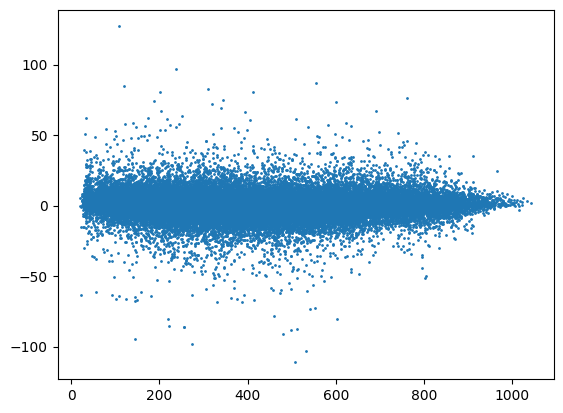

In [109]:
plt.scatter(tp.motion.velocity_corr(tm, 0, 1).r,tp.motion.velocity_corr(tm, 0, 1).dot_product, s=1)

In [135]:
gr=tp.static.pair_correlation_2d(tm[tm.frame==27], 1000, fraction=1.0, dr=30, p_indices=None, ndensity=None, boundary=None, handle_edge=True, max_rel_ndensity=10)

In [115]:
gr

(array([0.000e+00, 5.000e-01, 1.000e+00, ..., 9.990e+02, 9.995e+02,
        1.000e+03]),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.10934291,
        0.        ]))

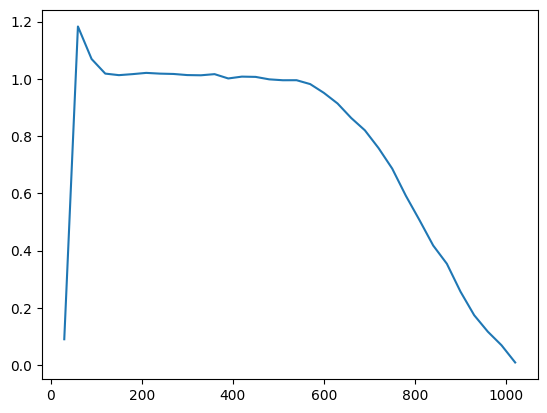

In [136]:
plt.plot(gr[0][:-1]+np.diff(gr[0]), gr[1])

20.864421109048468

In [5]:
dist=cdist(np.array([dat_df[dat_df.time==135].cc_x,dat_df[dat_df.time==135].cc_y]).T,np.array([dat_df[dat_df.time==135].cc_x,dat_df[dat_df.time==135].cc_y]).T)
np.mean(dist[np.where(shell_matrix==1)])
radius=0.5*np.mean(dist[np.where(shell_matrix==1)])

In [22]:

[np.mean(shape_cos_sq[i,np.where(shell_matrix[i]==1)]) for i in range(len(shell_matrix))]

[0.49213365935922476,
 0.49818575237412993,
 0.5945989542254471,
 0.627242365752201,
 0.6422805677482044,
 0.4696295805082461,
 0.7854114268935551,
 0.5078599925698258,
 0.7072326842838248,
 0.6253200401264981,
 0.7298835319120579,
 0.7360716000199478,
 0.3895539336801018,
 0.8994023607434173,
 0.4249743916493182,
 0.509439066094092,
 0.720946954022933,
 0.38412854915435846,
 0.6359334473651999,
 0.6278897559038208,
 0.7568616500300485,
 0.5737742997915503,
 0.30072341367309546,
 0.7214778260049676,
 0.4079604786039176,
 0.4786269474403831,
 0.1292894123546309,
 0.7757898194694879,
 0.39549373621087835,
 0.6610049297608886,
 0.6622460980926856,
 0.5554323950373241,
 0.46979361079916043,
 0.40571586864586884,
 0.44050083706518806,
 0.4081926161876335,
 0.7816159691092311,
 0.5701607367965117,
 0.5222821948123253,
 0.7682225889363977,
 0.546461105965146,
 0.3740016137389398,
 0.4468694891678437,
 0.5780723771882653,
 0.6350314040599756,
 0.7805852482700847,
 0.6107485231632417,
 0.665489

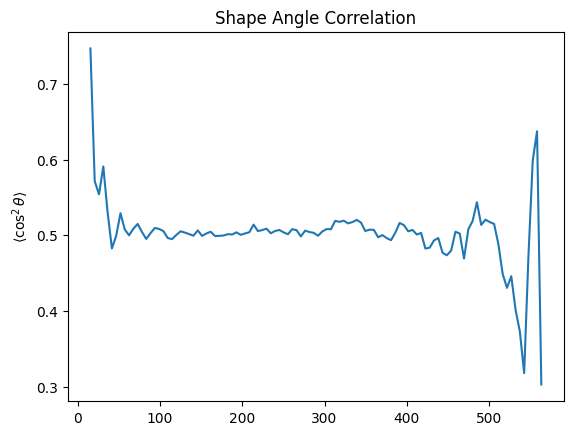

In [13]:
fig, ax=plt.subplots()

n=len(shell_files)
colour = iter(cm.rainbow_r(np.linspace(0, 1,n)))

for i in range(n):
    c=next(colour)
    shell_matrix=np.loadtxt(shell_files[i])
    shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads.values,dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads.values))**2
    r = np.sqrt(np.subtract.outer(dat_df[dat_df.tm_frame==i].cc_x.values, dat_df[dat_df.tm_frame==i].cc_x.values)**2 +
                np.subtract.outer(dat_df[dat_df.tm_frame==i].cc_y.values, dat_df[dat_df.tm_frame==i].cc_y.values)**2)
    #upper_triangle = np.triu_indices_from(shell_matrix, 1)
    upper_triangle = np.triu_indices_from(r, 1)

    c_func_shape_r=pd.concat([c_func_shape_r,pd.DataFrame({'r': r[upper_triangle],'cos_sq': shape_cos_sq[upper_triangle]})])

n=101
#bins=np.linspace(c_func.r.min(),c_func.r.max(), n)
bins=np.arange(0, c_func_shape_r.r.max(), 0.5*radius)
shape_corr=[]
for i in range(1,len(bins)):
    c_bin=c_func_shape_r[(c_func_shape_r.r>bins[i-1])&(c_func_shape_r.r<=bins[i])]
    mean_corr=c_bin.cos_sq.mean()
    shape_corr.append(mean_corr)

plt.plot(bins[:-1]+np.diff(bins), shape_corr)

# sns.lineplot(ax=ax,data=c_func_shape_r, y='cos_sq', x='shell',err_style='bars', errorbar='se', label=str(i*5), c=c)
# plt.legend(title='time')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.ylabel(r'$\langle\cos ^2 \theta\rangle$')
plt.title('Shape Angle Correlation')
plt.show()
    #plt.xlim(0, 20)
    #plt.ylim(0.4, 0.85)
#plt.savefig(plot_dir+'/shape_angle_correlations_nn_shells.png', dpi=300, bbox_inches='tight')
